# Setup

In [17]:
# Import needed libraries
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import nflreadpy as nfl
import seaborn as sns

from sklearn.preprocessing import StandardScaler

In [18]:
# Set display options
pd.set_option('display.max_rows', 1000)

# Import data

In [19]:
game_df = pd.read_csv('../data/game_data.csv')
game_df

,season,week,team,season_type,opponent_team,previous_game_completions,previous_game_attempts,previous_game_passing_yards,previous_game_passing_tds,previous_game_passing_interceptions,...,opponent_previous_season_average_gwfg_att,opponent_previous_season_average_gwfg_missed,opponent_previous_season_average_gwfg_blocked,opponent_previous_season_average_gwfg_distance,opponent_previous_season_average_opponent_points_scored,opponent_previous_season_average_outcome,opponent_previous_season_average_points_scored,had_bye_week_last,opponent_had_bye_week_last,outcome
0,2008,1,ARI,REG,SF,23.0,39.0,300.0,3.0,2.0,...,0.062500,0.0625,0.000000,3.250000,22.375000,0.281250,13.187500,1,1,1.0
1,2008,1,ATL,REG,DET,17.0,27.0,251.0,4.0,0.0,...,0.062500,0.0000,0.000000,2.312500,27.250000,0.437500,21.125000,1,1,1.0
2,2008,1,BAL,REG,CIN,16.0,27.0,171.0,1.0,0.0,...,0.000000,0.0000,0.000000,0.000000,24.062500,0.437500,22.875000,1,1,1.0
3,2008,1,BUF,REG,SEA,16.0,30.0,133.0,0.0,0.0,...,0.000000,0.0000,0.000000,0.000000,18.722222,0.611111,24.444444,1,1,1.0
4,2008,1,CAR,REG,LAC,15.0,24.0,174.0,2.0,1.0,...,0.000000,0.0000,0.000000,0.000000,17.000000,0.684211,23.736842,1,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9607,2025,13,SEA,REG,MIN,16.0,26.0,244.0,2.0,0.0,...,0.055556,0.0000,0.000000,1.611111,19.166667,0.777778,24.166667,0,0,1.0
9608,2025,13,SF,REG,CLE,23.0,32.0,193.0,1.0,3.0,...,0.000000,0.0000,0.000000,0.000000,25.588235,0.176471,14.705882,0,0,1.0
9609,2025,13,TB,REG,ARI,17.0,34.0,103.0,1.0,2.0,...,0.117647,0.0000,0.000000,3.882353,22.294118,0.411765,22.588235,0,0,1.0
9610,2025,13,TEN,REG,JAX,28.0,42.0,256.0,1.0,0.0,...,0.058824,0.0000,0.000000,2.882353,25.470588,0.235294,18.470588,0,0,0.0


In [20]:
odds_df = pd.read_csv('../data/odds_data.csv')
odds_df

,season,week,team,opponent_team,home_probability,away_probability
0,2009,8,ARI,CAR,0.816514,0.206186
1,2009,8,BAL,DEN,0.687500,0.340136
2,2009,8,BUF,HOU,0.367647,0.655172
3,2009,8,CHI,CLE,0.857143,0.175439
4,2009,8,DAL,SEA,0.833333,0.192308
...,...,...,...,...,...,...
4460,2025,15,PHI,LV,0.904762,0.137931
4461,2025,15,PIT,MIA,0.618321,0.423729
4462,2025,15,SEA,IND,0.649123,0.393701
4463,2025,15,SF,TEN,0.904762,0.137931


# Process data

In [21]:
def process_df(game_df, odds_df):
    '''
    - Removes unnecessary features
    - Merges game_df with odds_df
    - Splits the preprocessed df
    - Scales the features

    Parameters:
    game_df - the preprocessed team data returned from preprocess_team_data
    odds_df - the preprocessed odds data from preprocess_schedule_data

    Returns:
    X_train, y_train, X_val, y_val, X_test, y_test - feature matrix and responders
    '''

    # Merge Data
    df = game_df.merge(odds_df, on=['season', 'week', 'team', 'opponent_team'], how='inner')

    # # # # # # # # #
    # Drop Columns  #
    # # # # # # # # #

    # Discard draws - draws happen ~0.005% of the time
    # Since the application of this project is to outperform sportsbooks, 
    # and they discard the bet on a draw, we can safely ignore the draw 
    # from our data to only predict wins/losses
    df = df.query('outcome != 0.5')

    # Discard team names - we don't want to learn patterns from team names since 
    # they can change drastically from season to season.
    # e.g. Patriots dynasty occurs exclusively in train data (ended when Tom Brady left)
    df = df.drop(columns=['team', 'opponent_team'])

    # Turn season_type column into indicator for post-season 
    # (only takes on values regular and post season)
    df.rename(columns={'season_type': 'is_postseason'}, inplace=True)
    df['is_postseason'] = (df['is_postseason'] == 'POST').astype(int)

    # No field goals have ever been missed <20 yards out, so all these variables only have value 0
    df = df.drop(columns=['previous_game_fg_missed_0_19',
                          'opponent_previous_game_fg_missed_0_19',
                          'season_average_fg_missed_0_19',
                          'opponent_season_average_fg_missed_0_19',
                          'previous_season_average_fg_missed_0_19',
                          'opponent_previous_season_average_fg_missed_0_19'])
    
    df = df.reset_index(drop=True)
    
    # # # # # # # #
    # Split data  #
    # # # # # # # #

    # Since this is time series data, we want to split by seasons such that train < val < test in time
    # For this we will use train data < 2020, 2020 <= val data < 2023, 2023 <= test data
    train = df.query('season < 2020').reset_index(drop=True)
    X_train = train.drop(columns=['outcome'])
    y_train = train['outcome']
    
    val = df.query('season >= 2020 and season < 2023').reset_index(drop=True)
    X_val = val.drop(columns=['outcome'])
    y_val = val['outcome']
    
    test = df.query('season >= 2023').reset_index(drop=True)
    X_test = test.drop(columns=['outcome'])
    y_test = test['outcome']


    # # # # # # # # # #
    # Scale Features  #
    # # # # # # # # # #
    scale_features = [f for f in X_train.columns if f not in ['home_probability', 'away_probability']]
    scaler = StandardScaler()
    X_train[scale_features] = pd.DataFrame(scaler.fit_transform(X_train[scale_features]), columns=scale_features, index=X_train.index)
    X_val[scale_features] = pd.DataFrame(scaler.transform(X_val[scale_features]), columns=scale_features, index=X_val.index)
    X_test[scale_features] = pd.DataFrame(scaler.transform(X_test[scale_features]), columns=scale_features, index=X_test.index)

    return X_train, y_train, X_val, y_val, X_test, y_test

In [22]:
X_train, y_train, X_val, y_val, X_test, y_test = process_df(game_df, odds_df)

# EDA

In [23]:
df_train = X_train.copy()
df_train['outcome'] = y_train

In [24]:
# Highest correlated variables with outcome
X_train.corrwith(y_train).loc[
    X_train.corrwith(y_train).abs().sort_values(ascending=False).index
].head(20).index

Index(['away_probability', 'home_probability', 'season_average_outcome',
       'season_average_passing_epa', 'season_average_points_scored',
       'season_average_receiving_epa', 'season_average_opponent_points_scored',
       'opponent_season_average_points_scored',
       'previous_season_average_points_scored',
       'opponent_season_average_passing_epa',
       'previous_season_average_outcome',
       'opponent_season_average_receiving_epa',
       'opponent_season_average_passing_cpoe',
       'previous_season_average_pat_made', 'previous_season_average_pat_att',
       'opponent_season_average_outcome', 'season_average_pat_att',
       'opponent_season_average_pat_att', 'opponent_season_average_pat_made',
       'season_average_pat_made'],
      dtype='object')

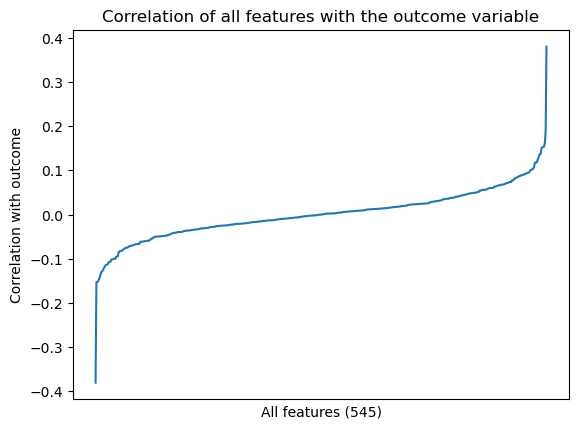

In [25]:
# Show the range of correlations with the target variable
plt.plot(X_train.corrwith(y_train).sort_values())
plt.xticks(ticks=[], labels=[])
plt.xlabel('All features (545)')
plt.ylabel('Correlation with outcome')
plt.title('Correlation of all features with the outcome variable')
plt.savefig('../figures/correlations_across_all_features.png', dpi=300, bbox_inches='tight')
plt.show()

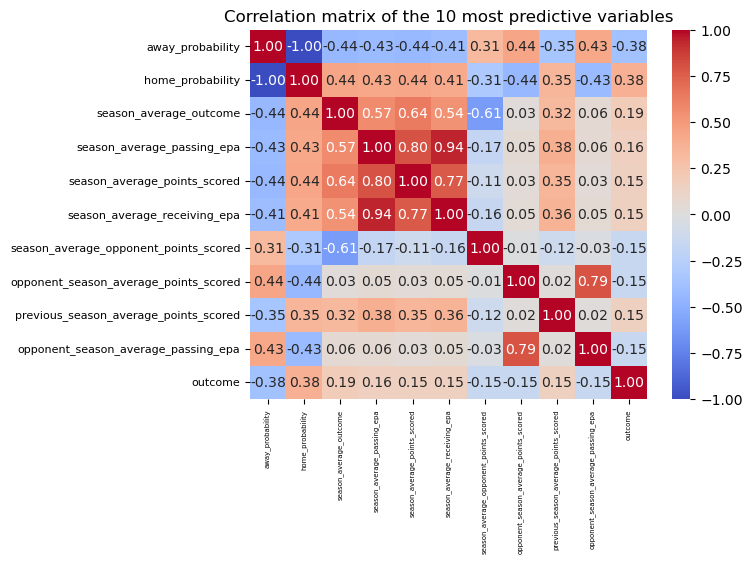

In [26]:
# Correlation matrix of top 10 features
sns.heatmap(df_train[['away_probability', 'home_probability', 'season_average_outcome',
       'season_average_passing_epa', 'season_average_points_scored',
       'season_average_receiving_epa', 'season_average_opponent_points_scored',
       'opponent_season_average_points_scored',
       'previous_season_average_points_scored',
       'opponent_season_average_passing_epa', 'outcome']].corr(), 
       cmap='coolwarm', vmin=-1, vmax=1, annot=True, fmt='.2f')
plt.title('Correlation matrix of the 10 most predictive variables')
plt.xticks(fontsize=5)
plt.yticks(fontsize=8)
plt.savefig('../figures/correlation_matrix_10_most_predictive_features.png', dpi=300, bbox_inches='tight')
plt.show()


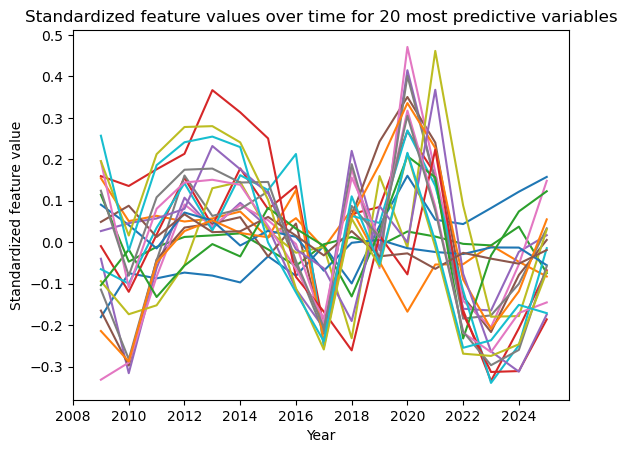

In [27]:
# Plot 20 most correlated variables (standardized) over time
df = game_df.merge(odds_df, on=['season', 'week', 'team', 'opponent_team'], how='inner')
for c in ['away_probability', 'home_probability', 'season_average_outcome',
       'season_average_passing_epa', 'season_average_points_scored',
       'season_average_receiving_epa', 'season_average_opponent_points_scored',
       'opponent_season_average_points_scored',
       'previous_season_average_points_scored',
       'opponent_season_average_passing_epa',
       'previous_season_average_outcome',
       'opponent_season_average_receiving_epa',
       'opponent_season_average_passing_cpoe',
       'previous_season_average_pat_made', 'previous_season_average_pat_att',
       'opponent_season_average_outcome', 'season_average_pat_att',
       'opponent_season_average_pat_att', 'opponent_season_average_pat_made',
       'season_average_pat_made']:
    plt.plot((df.groupby('season')[c].mean() - df[c].mean())/df[c].std())
plt.xticks(ticks=range(2008, 2026, 2))
plt.xlabel('Year')
plt.ylabel('Standardized feature value')
plt.title('Standardized feature values over time for 20 most predictive variables')
plt.savefig('../figures/feature_values_over_time_20_most_predictive.png', dpi=300, bbox_inches='tight')
plt.show()

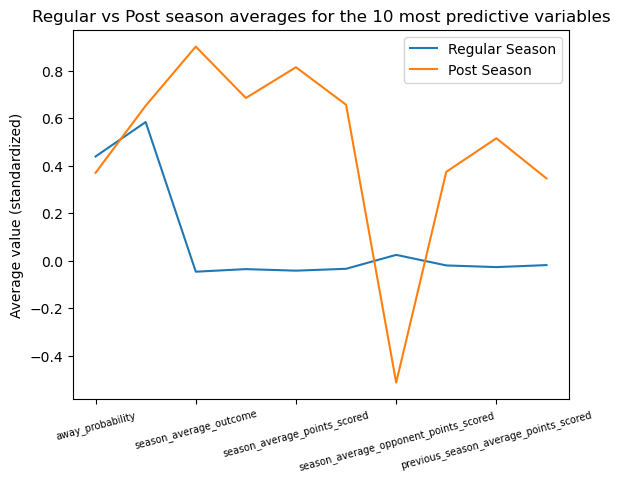

In [28]:
# Plot means of 10 most predictive features in reg vs post season
X_train.groupby('is_postseason')[['away_probability', 'home_probability', 'season_average_outcome',
       'season_average_passing_epa', 'season_average_points_scored',
       'season_average_receiving_epa', 'season_average_opponent_points_scored',
       'opponent_season_average_points_scored',
       'previous_season_average_points_scored',
       'opponent_season_average_passing_epa']].mean().T.plot()
plt.legend(labels=['Regular Season', 'Post Season'])
plt.ylabel('Average value (standardized)')
plt.title('Regular vs Post season averages for the 10 most predictive variables')
plt.xticks(rotation=15, fontsize=7)
plt.savefig('../figures/reg_vs_post_feature_averages_10_most_predictive.png', dpi=300, bbox_inches='tight')
plt.show()

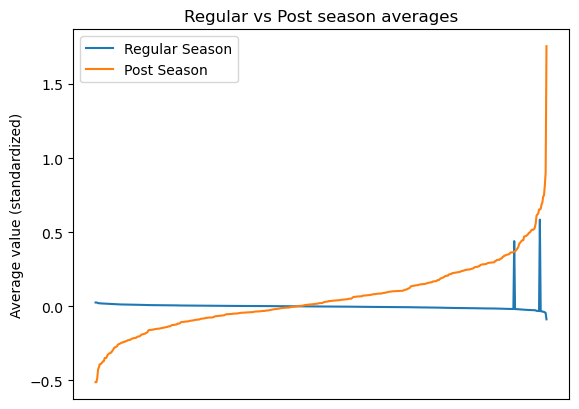

In [29]:
# Plot feature average in reg vs post season
X_train.groupby('is_postseason').mean().T.sort_values(by=X_train.groupby('is_postseason').mean().T.columns[1]).plot()
plt.legend(labels=['Regular Season', 'Post Season'])
plt.ylabel('Average value (standardized)')
plt.title('Regular vs Post season averages')
plt.xticks(ticks=[], labels=[])
plt.savefig('../figures/reg_vs_post_feature_averages.png', dpi=300, bbox_inches='tight')
plt.show()

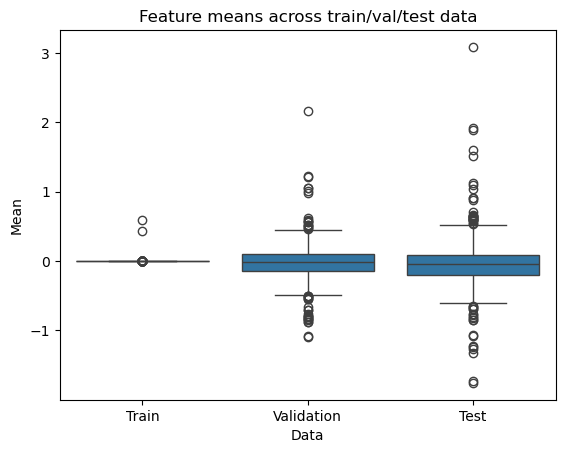

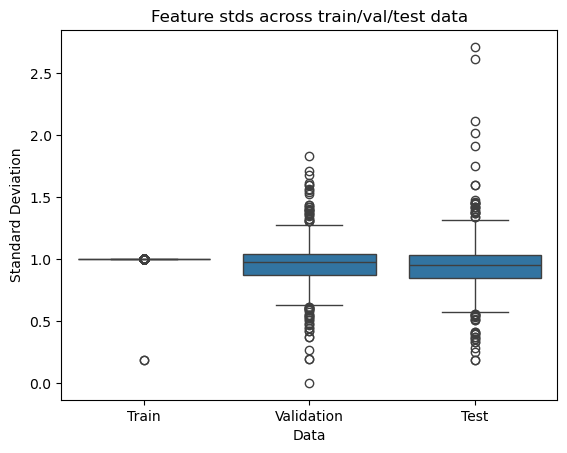

In [30]:
# Feature mean/std in train/val/test
sns.boxplot(
    data=pd.concat([
        X_train.describe().T['mean'].rename('Train'),
        X_val.describe().T['mean'].rename('Validation'),
        X_test.describe().T['mean'].rename('Test')
    ], axis=1).melt(var_name='Data', value_name='Mean'),
    x='Data',
    y='Mean'
)
plt.title('Feature means across train/val/test data')
plt.savefig('../figures/feature_means_across_train_val_test.png', dpi=300, bbox_inches='tight')
plt.show()

sns.boxplot(
    data=pd.concat([
        X_train.describe().T['std'].rename('Train'),
        X_val.describe().T['std'].rename('Validation'),
        X_test.describe().T['std'].rename('Test')
    ], axis=1).melt(var_name='Data', value_name='Standard Deviation'),
    x='Data',
    y='Standard Deviation'
)
plt.title('Feature stds across train/val/test data')
plt.savefig('../figures/feature_stds_across_train_val_test.png', dpi=300, bbox_inches='tight')
plt.show()